Reading the Excel file...
Excel file read successfully. Data shape: (51, 11)
Geocoding the locations...
Geocoded Philadelphia, Pennsylvania -> 39.9527237, -75.1635262
Geocoded New York City, New York -> 40.7127281, -74.0060152
Geocoded Hamburg (Germany), Germany/New York -> 43.233173, -77.487667
Geocoded Philadelphia, Pennsylvania -> 39.9527237, -75.1635262
Geocoded New York City, New York -> 40.7127281, -74.0060152
Geocoded Maryland, Baltimore -> 39.2908816, -76.610759
Geocoded Philadelphia, Pennsylvania -> 39.9527237, -75.1635262
Geocoded New York City, New York -> 40.7127281, -74.0060152
Geocoded Charleston , South Carolina -> 32.7884363, -79.9399309
Geocoded Boston, Massachusetts -> 42.3554334, -71.060511
Geocoded Baltimore, Maryland -> 39.2908816, -76.610759
Geocoded New York City, New York -> 40.7127281, -74.0060152
Geocoded Philadelphia, Pennsylvania -> 39.9527237, -75.1635262
Geocoded Baltimore, Maryland -> 39.2908816, -76.610759
Geocoded New York City, New York -> 40.7127281, 

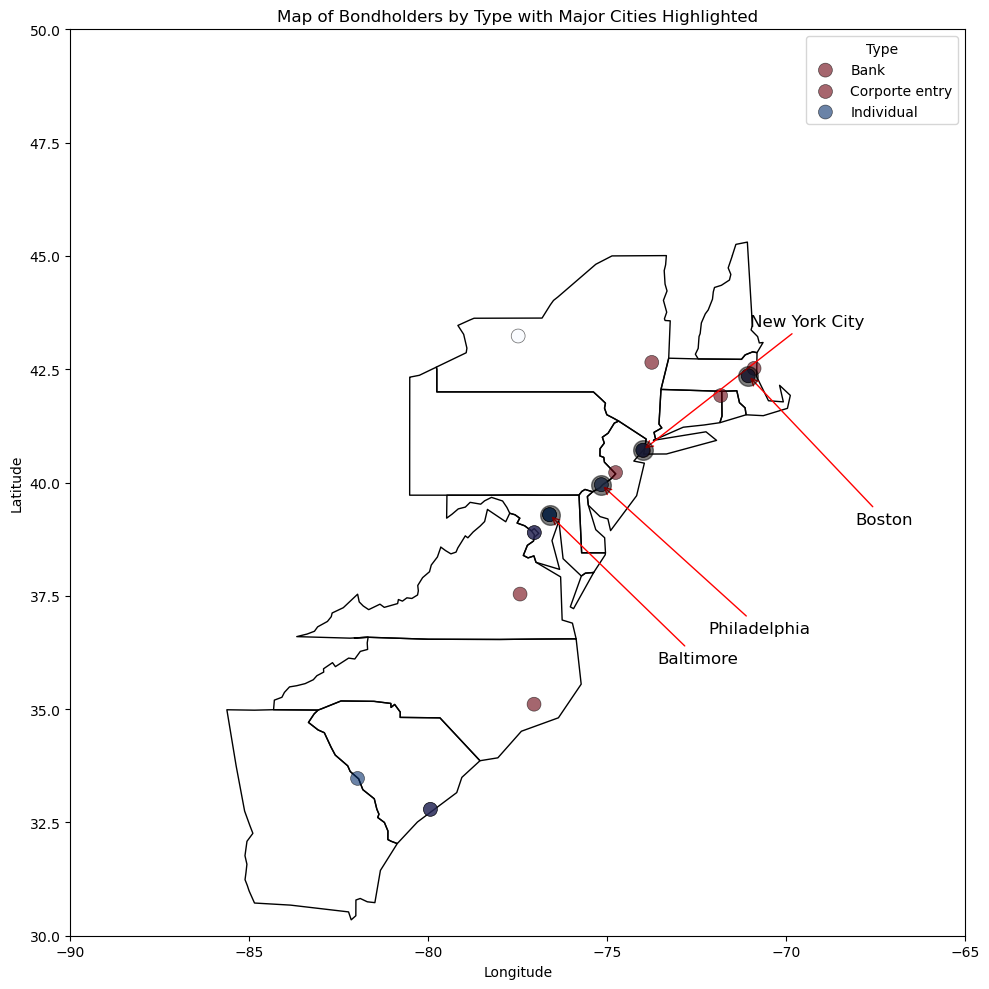

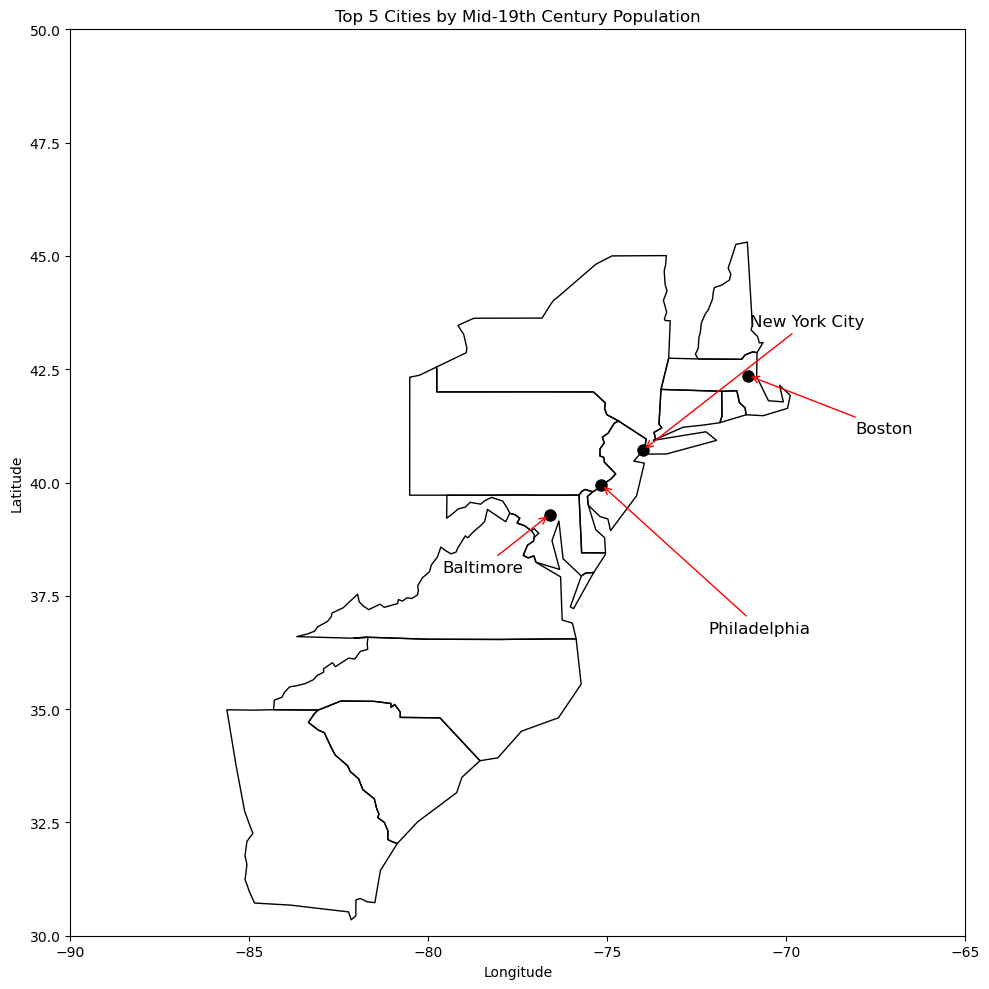

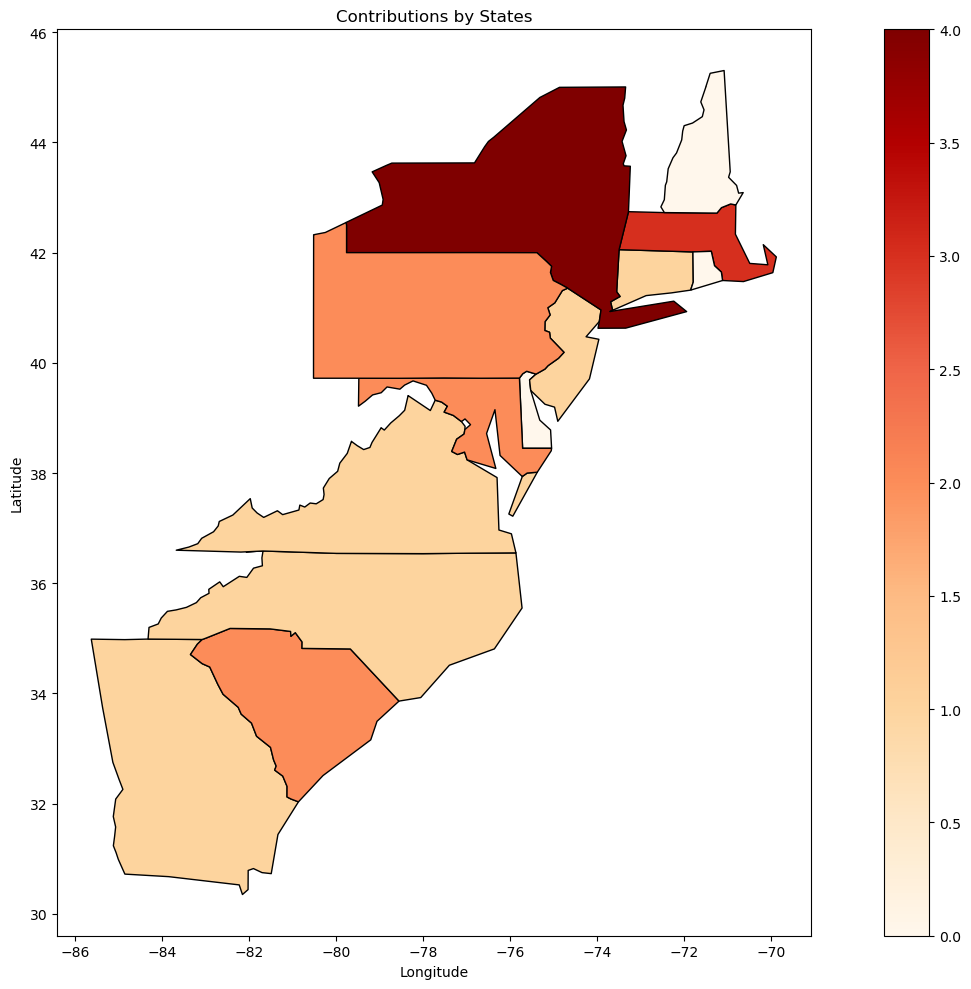

In [2]:
import geopandas as gpd
import pandas as pd
from geopy.extra.rate_limiter import RateLimiter
from opencage.geocoder import OpenCageGeocode
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

file_path = 'data/Bondholders and the Second bank.xlsx'
print("Reading the Excel file...")
data = pd.read_excel(file_path)
print(f"Excel file read successfully. Data shape: {data.shape}")

key = '077887432ade4ec9a6c62c864edbd89e'
geocoder = OpenCageGeocode(key)
geocode = RateLimiter(geocoder.geocode, min_delay_seconds=1)

def get_location(row):
    try:
        location = geocode(f"{row['Town']}, {row['State']}")
        if location:
            print(f"Geocoded {row['Town']}, {row['State']} -> {location[0]['geometry']['lat']}, {location[0]['geometry']['lng']}")
            return pd.Series([location[0]['geometry']['lat'], location[0]['geometry']['lng']])
        location = geocode(row['State'])
        if location:
            print(f"Geocoded {row['State']} -> {location[0]['geometry']['lat']}, {location[0]['geometry']['lng']}")
            return pd.Series([location[0]['geometry']['lat'], location[0]['geometry']['lng']])
    except Exception as e:
        print(f"Error: {e} for {row['Town']}, {row['State']}")
        return pd.Series([None, None])

print("Geocoding the locations...")

geo_data = data.apply(get_location, axis=1)
geo_data.columns = ['Latitude', 'Longitude']

mapped_data = data.join(geo_data)

mapped_data.dropna(subset=['Latitude', 'Longitude'], inplace=True)
print(f"Mapped data shape after dropping NaNs: {mapped_data.shape}")

relevant_states = ["New York", "Pennsylvania", "New Jersey", "Delaware", "Maryland", "Virginia", 
                   "Massachusetts", "Connecticut", "Georgia", "North Carolina", "South Carolina",
                   "New Hampshire", "Rhode Island"]

us_states = gpd.read_file('/Users/sanjeevsubramanian/Downloads/ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp')
us_states = us_states[us_states['name'].isin(relevant_states)]

mapped_data['Town'] = mapped_data['Town'].replace({'Brooklyn': 'New York City'})

top_cities = {
    'New York City': (40.7128, -74.0060),
    'Philadelphia': (39.9526, -75.1652),
    'Baltimore': (39.2904, -76.6122),
    'Boston': (42.3601, -71.0589)
}

grouped_data = mapped_data.groupby(['Town', 'State', 'Type']).agg({
    'Latitude': 'mean',
    'Longitude': 'mean',
    'Amount': 'mean'
}).reset_index()

if grouped_data.empty:
    print("No geocoded data found. Exiting.")
else:
    print("Plotting the data...")

    fig1, ax1 = plt.subplots(figsize=(15, 10))
    
    us_states.plot(ax=ax1, color='none', edgecolor='black')
    
    ax1.set_xlim([-90, -65])
    ax1.set_ylim([30, 50])
    
    cmap_individual = plt.get_cmap('Blues_r')
    cmap_bank = plt.get_cmap('Reds_r')

    norm = plt.Normalize(grouped_data['Amount'].min(), grouped_data['Amount'].max())

    for ctype, group in grouped_data.groupby('Type'):
        if ctype == 'Individual':
            colors = cmap_individual(norm(group['Amount']))
        else:
            colors = cmap_bank(norm(group['Amount']))
        group.plot(ax=ax1, kind='scatter', x='Longitude', y='Latitude', label=ctype, c=colors, s=100, alpha=0.6, edgecolor='k', linewidth=0.5)
    
    for city, (lat, lon) in top_cities.items():
        ax1.scatter(lon, lat, marker='o', color='black', s=200, alpha=0.5, edgecolor='k', linewidth=1, zorder=5)
        offset_x, offset_y = (3, 3) if city == 'New York City' else (3, -3)
        ax1.annotate(
            city, xy=(lon, lat), xytext=(lon + offset_x, lat + offset_y),
            arrowprops=dict(arrowstyle='->', color='red', lw=1),
            fontsize=12, color='black', ha='left', va='top'
        )
    
    plt.legend(title='Type', loc='upper right')
    plt.title('Map of Bondholders by Type with Major Cities Highlighted')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    fig2, ax2 = plt.subplots(figsize=(15, 10))
    
    us_states.plot(ax=ax2, color='none', edgecolor='black')
    
    ax2.set_xlim([-90, -65])
    ax2.set_ylim([30, 50])
    
    for city, (lat, lon) in top_cities.items():
        ax2.plot(lon, lat, marker='o', color='black', markersize=8)
        if city == 'Philadelphia':
            offset_x, offset_y = 3, -3
        elif city == 'Boston':
            offset_x, offset_y = 3, -1
        elif city == 'New York City':
            offset_x, offset_y = 3, 3
        else:
            offset_x, offset_y = -3 if lon < -75 else 3, -1 if lat < 40 else 1
        ax2.annotate(
            city, xy=(lon, lat), xytext=(lon + offset_x, lat + offset_y),
            arrowprops=dict(arrowstyle='->', color='red', lw=1),
            fontsize=12, color='black', ha='left', va='top'
        )
    
    plt.title('Top 5 Cities by Mid-19th Century Population')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(False)  
    plt.tight_layout()
    plt.show()

    state_contributions = grouped_data.groupby('State').size().reset_index(name='Counts')
    us_states = us_states.merge(state_contributions, left_on='name', right_on='State', how='left').fillna(0)
    
    fig3, ax3 = plt.subplots(figsize=(15, 10))
    us_states.plot(column='Counts', ax=ax3, legend=True, cmap='OrRd', edgecolor='black')
    
    plt.title('Contributions by States')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(False) 
    plt.tight_layout()
    plt.show()